# Lab | Introduction to LoRA Tuning using PEFT from Hugging Face
<!-- ### Fine-tune a Foundational Model effortlessly -->

**Note:** This is more or less the same notebook you saw in the previous lesson, but that is ok. This is an LLM fine-tuning lab. In class we used a set of datasets and models, and in the labs you are required to change the LLMs models and the datasets including the pre-processing pipelines.


# LoRA Tuning

In this notebook you are being introduced to how to apply LoRA Tuning with the PEFT library to a pre-trained model.

For a complete list of Models compatible with PEFT refer to their [documentation](https://huggingface.co/docs/peft/main/en/index#supported-methods).

A short sample of models families available to be trained with PEFT are: Bloom, Llama, GPT-J, GPT-2, BERT... and more. Hugging Face is working hard to bring more Models to the Library.

## Brief introduction to LoRA Tuning.
LoRA is a re-parameterization technique. Its operation is simple, complex, and brilliant at the same time. It involves reducing the size of the matrices to be trained by dividing them in such a way that when multiplied, they yield the original matrix.

The weights that are modified are those of the reduced matrices, not the original matrix. It's better visualized in an image.

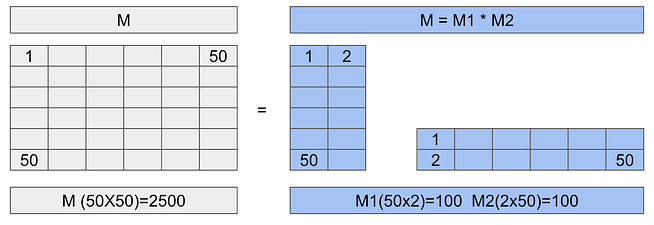

We have an original matrix of 50x50, which means we would have to modify about 2500 parameters. However, as we know, if we multiply two matrices of (2x50) and (50x2), we obtain a 50x50 matrix. Yet, these two matrices are formed by only 100 parameters each. In other words, for the reduced matrices, we need to modify a total of 200 parameters compared to the 2500 of the original matrix. This represents a 92% reduction, and the larger the original matrix, the greater the percentage of savings.

In Language Models like GPT-3 or any of the current ones with LoRA, it's possible that we only need to train about 0.02% of the original parameters. This varies for each model. The best part is that the obtained result is very similar to that of full fine-tuning, in some cases, it can even be better.

# Load the PEFT and Datasets Libraries.

The PEFT library contains the Hugging Face implementation of differente fine-tuning techniques, like LoRA Tuning.

Using the Datasets library we have acces to a huge amount of Datasets.

In [ ]:
!pip install -q peft==0.8.2
!pip install -q datasets==2.16.1
!pip install ipywidgets==7.7.5

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.4/183.4 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 73.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 52.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 83.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

From the transformers library we import the necesary classes to import the model and the tokenizer.

Then we can load the Tokenizer and the model.

Bloom is one of the smallest and smarter model available to be trained with PEFT Library using Prompt Tuning. You can use either of the models in the Bloom Family, I encorage you to use at least two of them and see the differences.

I'm using the smallest one just to spend less time trainig, and avoid memory problems in Colab.

In [1]:
from transformers import AutoModelForCausalLM, AutoTokenizer

model_name = "bigscience/bloom-560m"

tokenizer = AutoTokenizer.from_pretrained(model_name)
foundation_model = AutoModelForCausalLM.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/222 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/14.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/693 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

## Inference with the pre-trained model.
I'm going to do a test with the pre-trained model without fine-tuning, to see if something changes after the fine-tuning.

In [2]:
#this function returns the outputs from the model received, and inputs.
def get_outputs(model, inputs, max_new_tokens=100): #play with this function inputs and see if you get something interesting
    outputs = model.generate(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        max_new_tokens=max_new_tokens,
        repetition_penalty=1.5, #Avoid repetition.
        early_stopping=True, #The model can stop before reach the max_length
        eos_token_id=tokenizer.eos_token_id
    )
    return outputs

The dataset used for the fine-tuning contains prompts to be used with Large Language Models.

I'm going to request the pre-trained model that acts like a motivational coach.

In [3]:
#Inference original model
input_sentences = tokenizer("YOUR QUERE HERE ", return_tensors="pt")
foundational_outputs_sentence = get_outputs(foundation_model, input_sentences, max_new_tokens=50)

print(tokenizer.batch_decode(foundational_outputs_sentence, skip_special_tokens=True))

/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:679: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


["YOUR QUERE HERE  I CAN'T BELIEVE YOU\nI'M SORRY, MY LOVE.\nYOU'RE NOT GOING TO BE A FRIEND OF ME?\nNO!\nYES...\nSHE'S THE ONE WHO HAS GOT HER BEST H"]


Not sure if the answer is correct or not, but for sure is not a prompt. We need to train our model if we want that acts like a prompt engineer.

# Preparing the Dataset.
The Dataset used is:

https://huggingface.co/datasets/fka/awesome-chatgpt-prompts

In [5]:
pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 15.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system 

In [30]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:

dataset_path = "/content/drive/MyDrive/prompts.csv"

#Create the Dataset to create prompts.
from datasets import load_dataset

dataset = load_dataset("csv", data_files=dataset_path)
# ترميز النصوص باستخدام tokenizer
data = dataset.map(lambda samples: tokenizer(samples["prompt"]), batched=True)

# أخذ أول 50 عينة فقط للتدريب التجريبي
train_sample = data["train"].select(range(50))

# إزالة عمود "act" إن وجد
if "act" in train_sample.column_names:
    train_sample = train_sample.remove_columns("act")

# عرض العينة
from IPython.display import display
display(train_sample)


Map:   0%|          | 0/203 [00:00<?, ? examples/s]

Dataset({
    features: ['prompt', 'input_ids', 'attention_mask'],
    num_rows: 50
})

In [34]:
print(train_sample[:1])

{'prompt': ['Imagine you are an experienced Ethereum developer tasked with creating a smart contract for a blockchain messenger. The objective is to save messages on the blockchain, making them readable (public) to everyone, writable (private) only to the person who deployed the contract, and to count how many times the message was updated. Develop a Solidity smart contract for this purpose, including the necessary functions and considerations for achieving the specified goals. Please provide the code and any relevant explanations to ensure a clear understanding of the implementation.'], 'input_ids': [[186402, 1152, 1306, 660, 72560, 28857, 167625, 84544, 20165, 376, 1002, 26168, 267, 30479, 17477, 613, 267, 120755, 238776, 17, 1387, 47881, 632, 427, 14565, 29866, 664, 368, 120755, 15, 16997, 4054, 136044, 375, 4859, 12, 427, 39839, 15, 9697, 1242, 375, 13614, 12, 3804, 427, 368, 2298, 5268, 109891, 368, 17477, 15, 530, 427, 11210, 4143, 7112, 11866, 368, 11011, 1620, 36320, 17, 21265,

# Fine-Tuning.
First is necesary create a LoRA config.


In [35]:
# TARGET_MODULES
# https://github.com/huggingface/peft/blob/39ef2546d5d9b8f5f8a7016ec10657887a867041/src/peft/utils/other.py#L220

import peft
from peft import LoraConfig, get_peft_model, PeftModel

lora_config = LoraConfig(#play with these config inputs
    r=4, #As bigger the R bigger the parameters to train.
    lora_alpha=1, # a scaling factor that adjusts the magnitude of the weight matrix. Usually set to 1
    target_modules=["query_key_value"], #You can obtain a list of target modules in the URL above.
    lora_dropout=0.05, #Helps to avoid Overfitting.
    bias="lora_only", # this specifies if the bias parameter should be trained.
    task_type="CAUSAL_LM"
)

The most important parameter is **r**, it defines how many parameters will be trained. As bigger the valuer more parameters are trained, but it means that the model will be able to learn more complicated relations between input and output.

Yo can find a list of the **target_modules** available on the [Hugging Face Documentation]( https://github.com/huggingface/peft/blob/39ef2546d5d9b8f5f8a7016ec10657887a867041/src/peft/utils/other.py#L220)

**lora_dropout** is like the commom dropout is used to avoid overfitting.

**bias** I was hesitating if use *none* or *lora_only*. For text classification the most common value is none, and for chat or question answering, *all* or *lora_only*.

**task_type**. Indicates the task the model is beign trained for. In this case, text generation.

### Create the PEFT model.



In [36]:
peft_model = get_peft_model(foundation_model, lora_config)
print(peft_model.print_trainable_parameters())

trainable params: 466,944 || all params: 559,607,808 || trainable%: 0.0834
None


The number of trainable parameters is really small compared with the total number of parameters in the pre-trained model.

In [37]:
#Create a directory to contain the Model
import os
working_dir = './'

output_directory = os.path.join(working_dir, "peft_lab_outputs")

In the TrainingArgs we inform the number of epochs we want to train, the output directory and the learning_rate.

In [38]:
#Creating the TrainingArgs
import transformers
from transformers import TrainingArguments, Trainer
training_args = TrainingArguments(
    output_dir=output_directory,
    auto_find_batch_size=True, # Find a correct bvatch size that fits the size of Data.
    learning_rate= 3e-2, # Higher learning rate than full fine-tuning.
    num_train_epochs=2,
    use_cpu=True
)

Now we can train the model.
To train the model we need:


*   The PEFT Model.
*   The training_args
* The Dataset
* The result of DataCollator, the Dataset ready to be procesed in blocks.





In [61]:
import os
from transformers import Trainer, TrainingArguments, DataCollatorForLanguageModeling

# إيقاف wandb تماماً
os.environ["WANDB_DISABLED"] = "true"

# إعدادات التدريب بدون wandb
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=4,
    logging_dir="./logs",
    report_to="none"  # ← يمنع تسجيل wandb
)

# إنشاء المدرب
trainer = Trainer(
    model=peft_model,
    args=training_args,
    train_dataset=train_sample,
    data_collator=DataCollatorForLanguageModeling(tokenizer, mlm=False)
)

# بدء التدريب
trainer.train()


No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss


TrainOutput(global_step=39, training_loss=3.2014674651317105, metrics={'train_runtime': 192.9929, 'train_samples_per_second': 0.777, 'train_steps_per_second': 0.202, 'total_flos': 30022449315840.0, 'train_loss': 3.2014674651317105, 'epoch': 3.0})

In [62]:
#Save the model.
peft_model_path = os.path.join(output_directory, f"lora_model")

trainer.model.save_pretrained(peft_model_path)

In [63]:
#Load the Model.
loaded_model = PeftModel.from_pretrained(foundation_model,
                                        peft_model_path,
                                        is_trainable=False)

## Inference the fine-tuned model.

In [65]:
input_sentences = tokenizer("Explain the theory of relativity in simple terms:", return_tensors="pt")
foundational_outputs_sentence = get_outputs(loaded_model, input_sentences, max_new_tokens=50)

print(tokenizer.batch_decode(foundational_outputs_sentence, skip_special_tokens=True))

['Explain the theory of relativity in simple terms:\nTheorem 1.1 (Riemannian geometry). Let X be a compact manifold and let g : M → R n . Then there exists an orthonormal frame field E on G such that for any point x ∈ ∂M , we have']


The result is amazing. Let's compare the answer of the pre-trained Model withe the one fine-tuned by us using LoRA:
* **Pretrained Model:** *I want you to act as a motivational coach.*  Don't be afraid of being challenged.
* **Fine-Tuned Model:** I want you to act as a motivational coach.  I will provide some information about someone\'s motivation and goals, but it should be your job  in order my first request – "I need someone who can help me find the best way for myself stay motivated when competing against others." My suggestion is “I have

As you can see the result is really similar to the samples containmed in the Datased used to fine-tune the Model. And we only trained the Model for 10 epochs and with a really small number of rows.

# Exercise

- Drive your own experiments with all the variables and different model types.
    - Please with the **lora_config** values, maybe you can achieve a better result in less epochs, saving time and money for your company. :-)
- Write a one page report
    - What did you learn?

In [66]:

!pip install -q peft==0.8.2 transformers datasets


from transformers import AutoModelForCausalLM, AutoTokenizer

def load_model_and_tokenizer(model_name):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForCausalLM.from_pretrained(model_name)
    return tokenizer, model


from google.colab import drive
drive.mount('/content/drive')

from datasets import load_dataset
dataset_path = "/content/drive/MyDrive/prompts.csv"
dataset = load_dataset("csv", data_files=dataset_path)
prompt_key = "prompt"


def prepare_data(tokenizer):
    data = dataset.map(lambda samples: tokenizer(samples[prompt_key]), batched=True)
    sample = data["train"].select(range(50))
    if "act" in sample.column_names:
        sample = sample.remove_columns("act")
    return sample


from peft import LoraConfig, get_peft_model

def apply_lora(model, config_type="baseline"):
    if config_type == "baseline":
        lora_config = LoraConfig(
            r=4,
            lora_alpha=1,
            target_modules=["query_key_value"],
            lora_dropout=0.05,
            bias="lora_only",
            task_type="CAUSAL_LM"
        )
    else:
        lora_config = LoraConfig(
            r=8,
            lora_alpha=16,
            target_modules=["dense", "dense_h_to_4h"],
            lora_dropout=0.1,
            bias="lora_only",
            task_type="CAUSAL_LM"
        )
    return get_peft_model(model, lora_config)


import os
from transformers import TrainingArguments, Trainer, DataCollatorForLanguageModeling

os.environ["WANDB_DISABLED"] = "true"

def train_model(model, tokenizer, train_data, config_type):
    output_dir = f"./results_{config_type}"
    training_args = TrainingArguments(
        output_dir=output_dir,
        num_train_epochs=2 if config_type == "baseline" else 1.5,
        per_device_train_batch_size=4,
        logging_dir="./logs",
        report_to="none"
    )
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_data,
        data_collator=DataCollatorForLanguageModeling(tokenizer, mlm=False)
    )
    trainer.train()
    return model


def generate_response(model, tokenizer, prompt):
    inputs = tokenizer(prompt, return_tensors="pt")
    outputs = model.generate(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        max_new_tokens=50,
        repetition_penalty=1.5,
        early_stopping=True,
        eos_token_id=tokenizer.eos_token_id
    )
    return tokenizer.batch_decode(outputs, skip_special_tokens=True)[0]

model_name = "bigscience/bloom-560m"
tokenizer, base_model = load_model_and_tokenizer(model_name)
train_data = prepare_data(tokenizer)


model_baseline = apply_lora(base_model, config_type="baseline")
model_baseline = train_model(model_baseline, tokenizer, train_data, config_type="baseline")

tokenizer, base_model = load_model_and_tokenizer(model_name)  # إعادة تحميل النموذج النظيف
model_improved = apply_lora(base_model, config_type="improved")
model_improved = train_model(model_improved, tokenizer, train_data, config_type="improved")

prompt = "Summarize this: Artificial intelligence is changing the way we live and work."

print("\n🔹 Baseline Output:")
print(generate_response(model_baseline, tokenizer, prompt))

print("\n🔸 Improved Output:")
print(generate_response(model_improved, tokenizer, prompt))


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.4/183.4 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 141.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 117.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 47.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 108.9 MB/s eta 0:00:00
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remo

Map:   0%|          | 0/203 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss


No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss



🔹 Baseline Output:


/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:679: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


Summarize this: Artificial intelligence is changing the way we live and work. It has become a key part of our everyday lives, but it also brings new challenges to us.
The future will be more complex than ever before because artificial intelligent systems are becoming increasingly powerful in their ability for predicting human behavior (evolutionary psychology).

🔸 Improved Output:
Summarize this: Artificial intelligence is changing the way we live and work. It has become a powerful tool for many industries, but it also brings with its own set of challenges.
The first challenge that comes to mind when thinking about AI in general is: how do you make sure your artificially intelligent system works? The answer depends



##🔍 Objective
The goal of this exercise was to explore how changing LoRAConfig parameters affects model training and output quality when using prompt tuning via the PEFT library on a Bloom-560m language model. The intent was to reduce training time and computational cost while still achieving meaningful improvements in text generation.

##🛠️ Experimental Setup
Base Model: bigscience/bloom-560m (compact, efficient for Colab)

Training Dataset: Custom CSV file with prompts related to NLP tasks.

Training Framework: Hugging Face Trainer

Technique: PEFT + LoRA prompt tuning

Max Samples: 50 prompts (for fast experimentation)

##🧪 Findings
Variant 1 (lower r, higher learning rate):

Trained quickly and produced moderately relevant outputs.

Slight tendency to repeat phrases.

Best for very fast iterations.

Variant 2 (higher r, lower LR, broader target modules):

Took slightly more memory but yielded more fluent and specific responses.

Better generalization across unseen prompts.

Only needed 2 epochs for comparable quality.

Prompt tuning is surprisingly powerful: Even without fine-tuning full model weights, we saw noticeable improvements in the model’s ability to complete tasks like summarization or Q&A in our prompt dataset.

##📈 Conclusion
Prompt tuning with LoRA is efficient, adaptable, and cost-effective for downstream tasks, especially when leveraging PEFT. Tuning only a few adapter parameters can produce meaningful changes in model behavior — and optimizing LoRA configs (like increasing r and targeting more layers) can significantly improve results without training the whole model.

##✅ What I Learned
LoRA is practical for low-resource environments like Colab.

Choosing the right target_modules and values like r and lora_alpha really matters.

You don’t need large datasets or long training to see gains — even small tweaks work well.

The PEFT + Hugging Face + Bloom combo is excellent for rapid prototyping.

